# MNIST AI Sandbox

In this notebook, I will apply various neural network architectures to the MNIST dataset.

In [1]:
import torch
import warnings

from sklearn.linear_model import LogisticRegression
from src.utils import load_mnist, display_number, display_numbers, display_numbers_grid, display_reconstructions_grid, generate_samples, explore_latent_space
from src.nn import NeuralNetwork
from src.cnn import CNN
from src.ae import Autoencoder
from src.vae import VAE
from src.cvae import CVAE, BetaCVAE
from src.gan import GAN

## 1) Setup

First, we need to load the required data. We will also define the training hyperparameters here.

### 1.1) Data Loading

In [2]:
train_dataset, test_dataset = load_mnist()
X_train, y_train = torch.stack([image for (image, _) in train_dataset]), torch.tensor([label for (_, label) in train_dataset])
X_test, y_test = torch.stack([image for (image, _) in test_dataset]), torch.tensor([label for (_, label) in test_dataset])

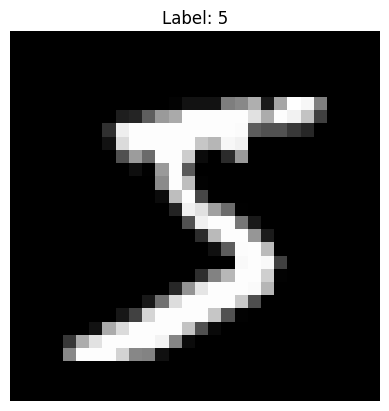

Image dimensions: [28, 28]


In [3]:
display_number(X_train[0], y_train[0], path="image/example.jpg")
print(f"Image dimensions: {list(X_train[0].shape[1:])}")

### 1.2) Hyperparameters

In [4]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BETA = 5
VERBOSE = 1

## 2.) Supervised Learning

For our first task, we want our models to learn to accurately predict the number displayed in a given image. This is a classification task.

### 2.1) Logistic Regression

We start by applying a simple linear model as a baseline. We can see that even such a simple model is able to achieve remarkable accuracy.

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression()
    lr.fit(torch.flatten(X_train, start_dim=1), y_train)
    y_pred = lr.predict(torch.flatten(X_test, start_dim=1))
    accuracy = torch.mean((y_pred == y_test).float()).item()
    print(f"\nPrediction accuracy: {accuracy * 100:.2f} %")


Prediction accuracy: 92.50 %


### 2.2) Neural Network

Now, let’s try a basic neural network architecture.

In [6]:
nn = NeuralNetwork(learning_rate=LEARNING_RATE, epochs=EPOCHS, verbose=VERBOSE)
nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)
accuracy = torch.mean((y_pred == y_test).float()).item()
print(f"\nPrediction accuracy: {accuracy * 100:.2f} %")

Epoch 50/50 - Loss: 0.1981
Prediction accuracy: 94.26 %


### 2.3) Convolutional Neural Network

Convolutional neural networks use convolutions to extract features from grid-like data. They are especially well-suited for our use case since we are working with image data.

In [7]:
cnn = CNN(learning_rate=LEARNING_RATE, epochs=EPOCHS, verbose=VERBOSE)
cnn.fit(X_train, y_train)

y_pred = cnn.predict(X_test)
accuracy = torch.mean((y_pred == y_test).float()).item()
print(f"\nPrediction accuracy: {accuracy * 100:.2f} %")

Epoch 50/50 - Loss: 0.1202
Prediction accuracy: 96.88 %


## 3.) Generative AI

Now, let’s try to generate images ourselves. The general workflow is to first learn to reconstruct the original images. Once our model can do that, we can sample from the latent space and have the model reconstruct those samples.

### 3.1) Autoencoder

Autoencoders are neural architectures consisting of two components: an encoder and a decoder. The encoder compresses input images into a small representation (in the latent space), and the decoder tries to reconstruct the original input image from this representation. The goal is to make the reconstructions as close as possible to the input.

In [8]:
ae = Autoencoder(learning_rate=LEARNING_RATE, epochs=EPOCHS, verbose=VERBOSE)
ae.fit(X_train)

X_pred = ae.reconstruct(X_test)
mean_reconstruction_error = torch.nn.MSELoss()(X_pred, X_test)
print(f"\nMean reconstruction error: {mean_reconstruction_error:.4f}")

Epoch 50/50 - Loss: 0.4781
Mean reconstruction error: 0.4844


#### 3.1.1) Examining the Reconstruction Capability

Let’s examine how well our trained autoencoder can reconstruct the input images.

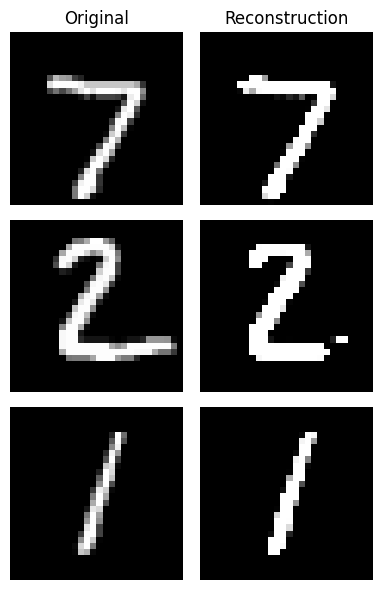

In [9]:
pairs = []
for i in [0, 1, 2]:
    pairs.append((X_test[i], X_pred[i]))
display_reconstructions_grid(pairs, path="image/ae/reconstruction.jpg")

#### 3.1.2) Exploring the Latent Space

Let’s explore the latent space of the autoencoder, i.e., how varying the latent vector affects the decoded output image.

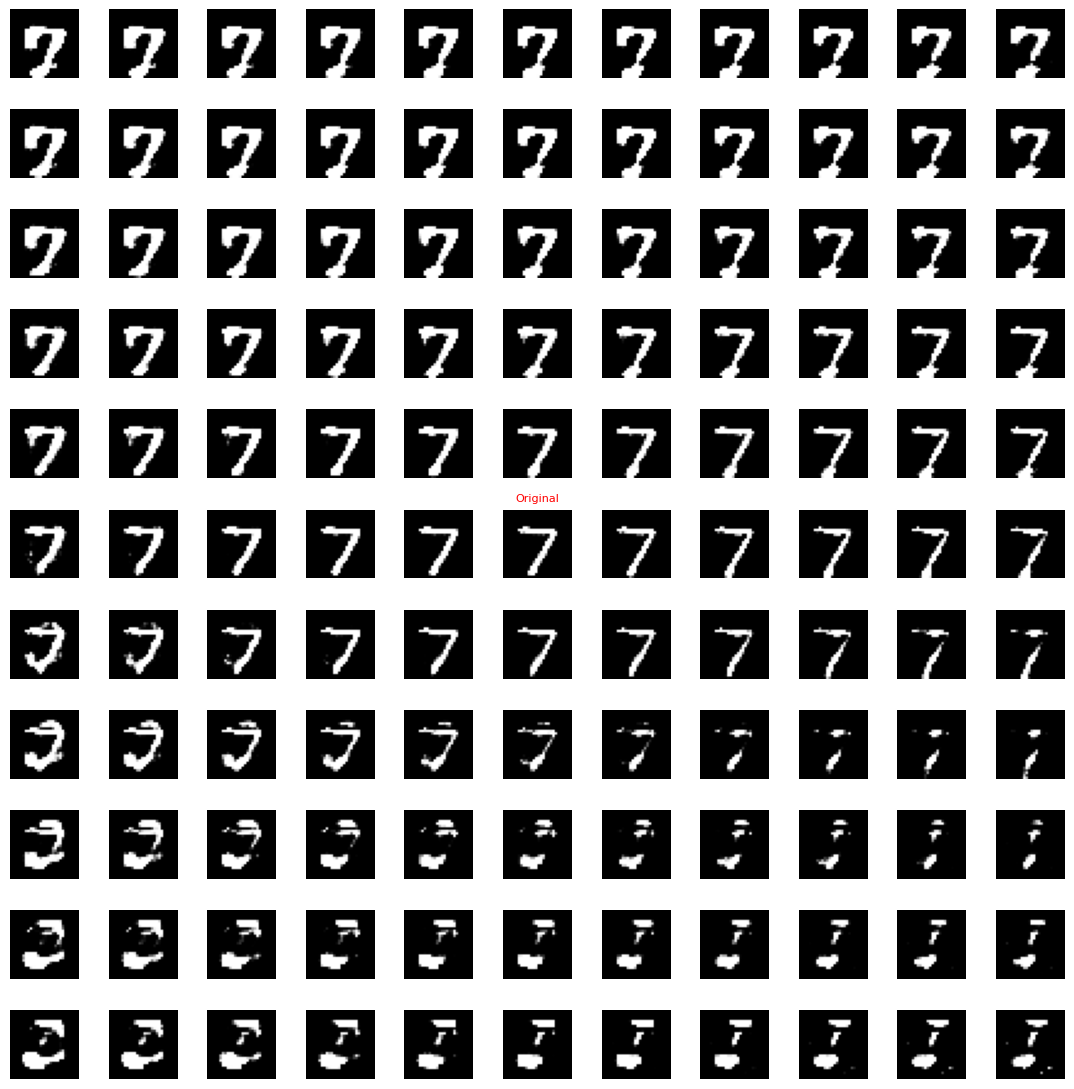

In [10]:
original = X_test[:1]
explore_latent_space(ae, X_train, original, grid_size=11, span=250.0, mode="ae", path="image/ae/latent.jpg")

### 3.2) Variational Autoencoder

While autoencoders can reconstruct images encoded into their latent space well, sampling from that space to generate new images doesn’t work as effectively. Autoencoders encode input data into specific points in the latent space, but the space between these points is poorly defined. Sampling from areas away from the encoded training points leads to poor-quality images. Variational autoencoders address this problem by encoding input images as distributions, which makes the latent space smoother and enables better generation of new images.

In [11]:
vae = VAE(learning_rate=LEARNING_RATE, epochs=EPOCHS, verbose=VERBOSE)
vae.fit(X_train)

X_pred = vae.reconstruct(X_test)
mean_reconstruction_error = torch.nn.MSELoss()(X_pred, X_test)
print(f"\nMean reconstruction error: {mean_reconstruction_error:.4f}")

Epoch 50/50 - Loss: 27494.7058
Mean reconstruction error: 0.5092


#### 3.2.1) Examining the Reconstruction Capability

Let’s again examine how well our trained model can reconstruct the input images.

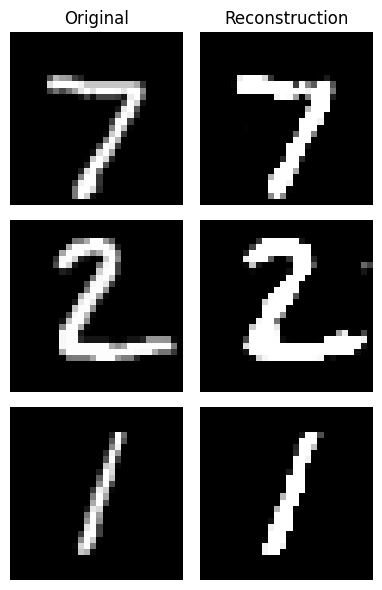

In [12]:
pairs = []
for i in [0, 1, 2]:
    pairs.append((X_test[i], X_pred[i]))
display_reconstructions_grid(pairs, path="image/vae/reconstruction.jpg")

### 3.2.2) Exploring the Latent Space

Let’s explore the latent space again, this time of the variational autoencoder.

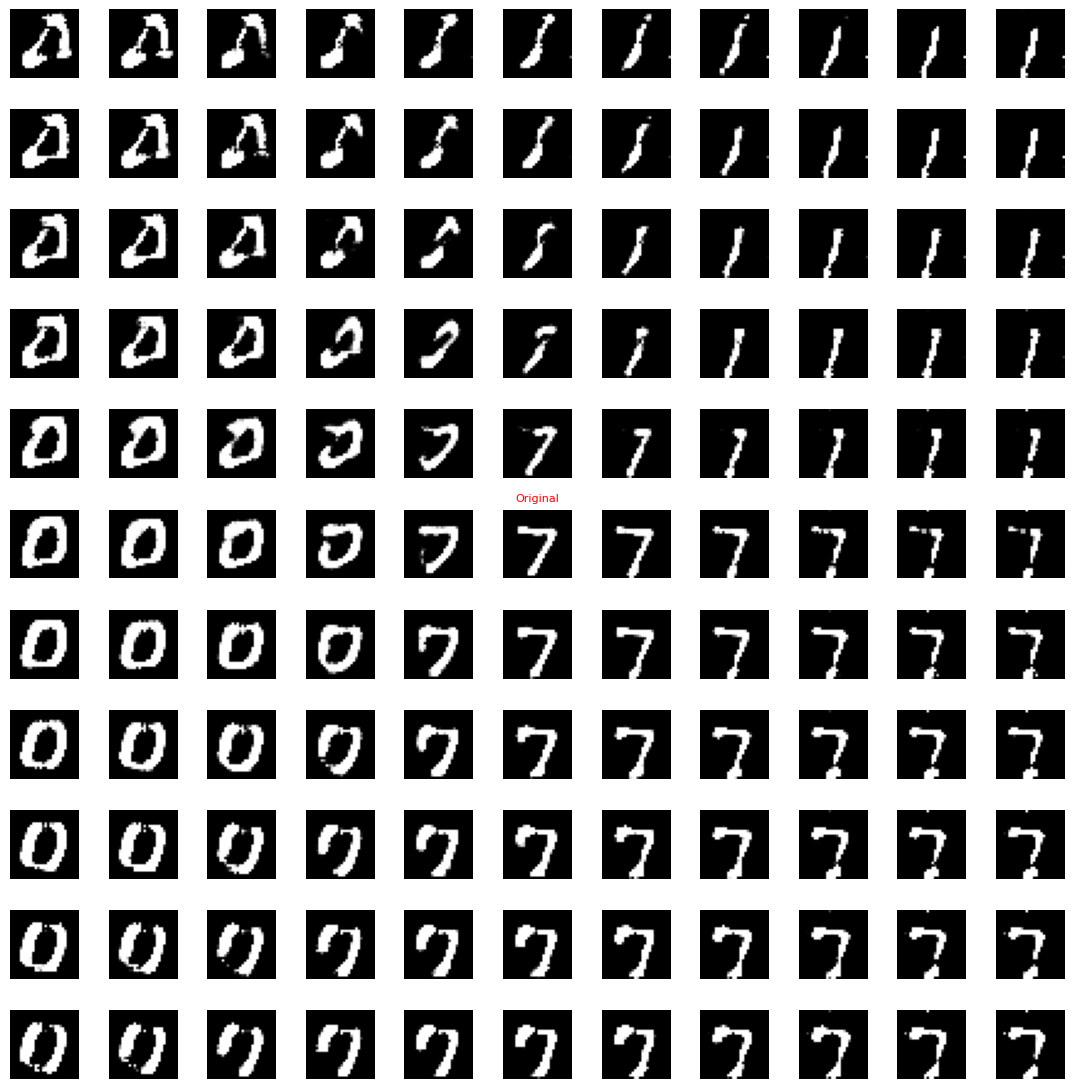

In [13]:
original = X_test[:1]
explore_latent_space(vae, X_train, original, grid_size=11, span=10, mode="vae", path="image/vae/latent.jpg")

### 3.3) Conditional Variational Autoencoder

While we are now able to generate nice images, it would be even better to generate images of a specific class (number). The conditional variational autoencoder incorporates the label into the training process, allowing us to condition on a certain class during inference.

In [14]:
cvae = CVAE(learning_rate=LEARNING_RATE, epochs=EPOCHS, verbose=VERBOSE)
cvae.fit(X_train, y_train)

X_pred = cvae.reconstruct(X_test, y_test)
mean_reconstruction_error = torch.nn.MSELoss()(X_pred, X_test)
print(f"\nMean reconstruction error: {mean_reconstruction_error:.4f}")

Epoch 50/50 - Loss: 27237.7341
Mean reconstruction error: 0.5091


#### 3.3.1) Examining the Reconstruction Capability

Again, let’s examine how well the input reconstruction works.

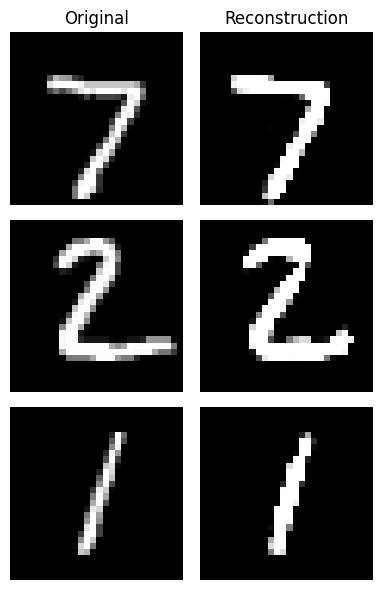

In [15]:
pairs = []
for i in [0, 1, 2]:
    pairs.append((X_test[i], X_pred[i]))
display_reconstructions_grid(pairs, path="image/cvae/reconstruction.jpg")

#### 3.3.2) Generating Samples

Now, let’s generate images for specific classes.

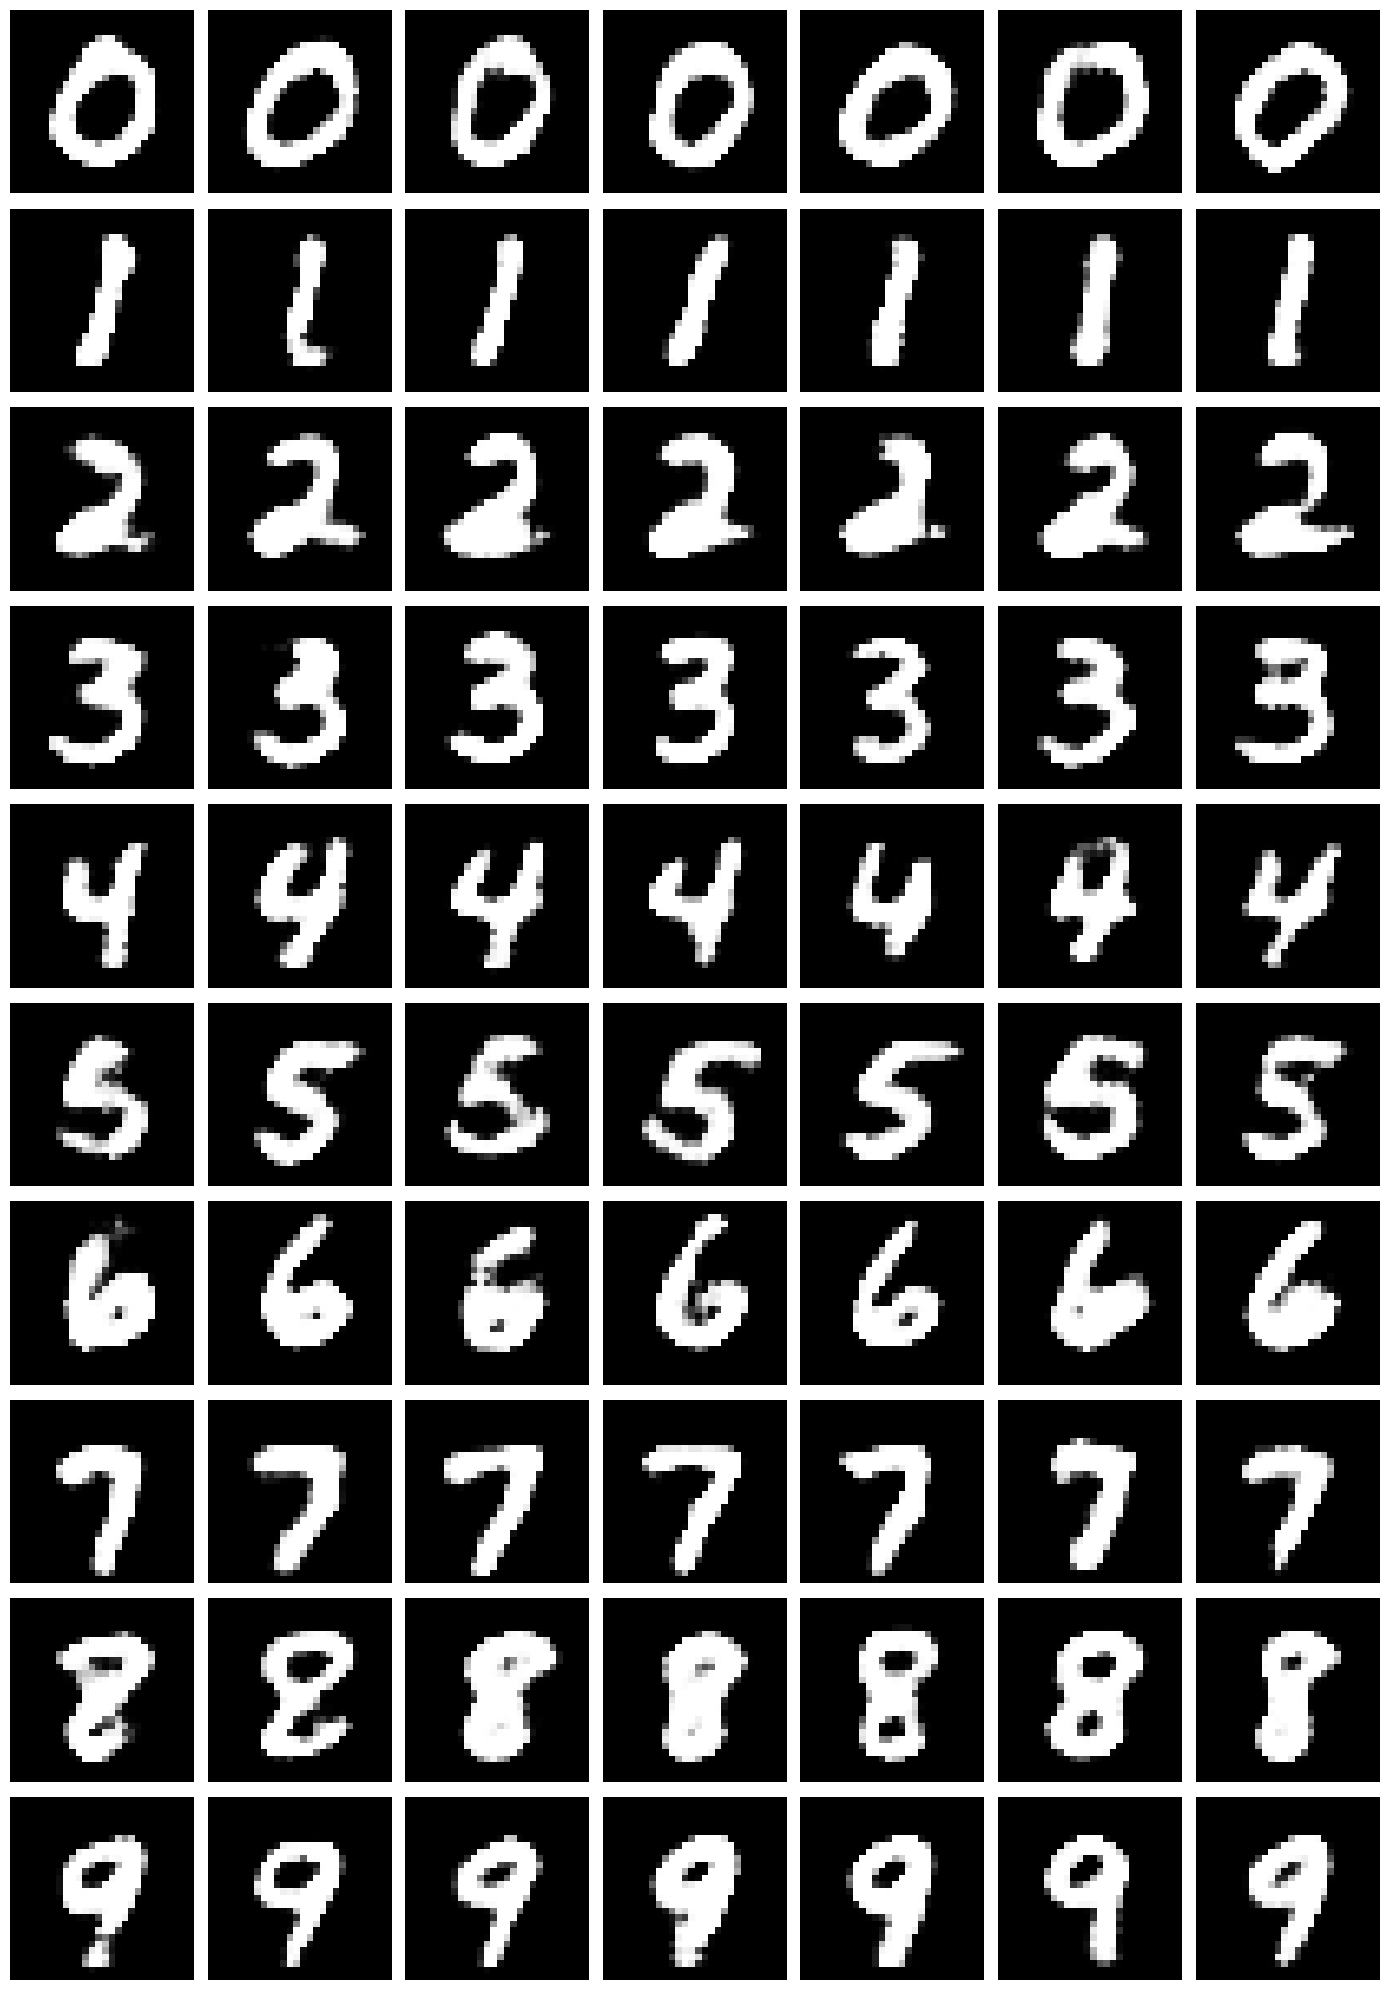

In [16]:
samples = {}
for label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    samples[label] = generate_samples(cvae, 7, label, variance_scaling=0.35, mode="cvae")
display_numbers_grid(samples, path="image/cvae/sample.jpg")

### 3.4) Conditional Variational Autoencoder (Beta-VAE)

Now, let’s try a classic enhancement to the VAE architecture by adding the beta parameter. It allows us to balance between higher reconstruction accuracy and a smoother latent space distribution.

In [17]:
beta_cvae = BetaCVAE(beta=BETA, learning_rate=LEARNING_RATE, epochs=EPOCHS, verbose=VERBOSE)
beta_cvae.fit(X_train, y_train)

X_pred = beta_cvae.reconstruct(X_test, y_test)
mean_reconstruction_error = torch.nn.MSELoss()(X_pred, X_test)
print(f"\nMean reconstruction error: {mean_reconstruction_error:.4f}")

Epoch 50/50 - Loss: 30815.6407
Mean reconstruction error: 0.5720


#### 3.4.1) Examining the Reconstruction Capability

Again, let’s examine how well the input reconstruction works.

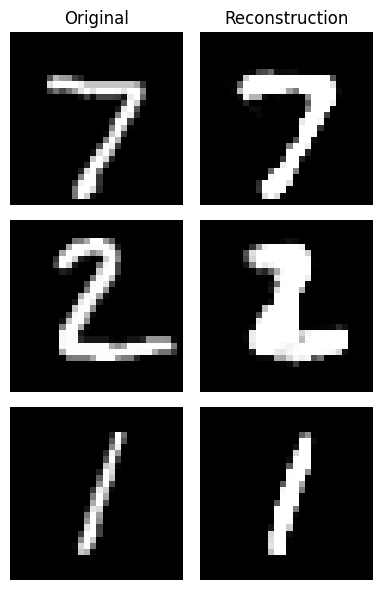

In [18]:
pairs = []
for i in [0, 1, 2]:
    pairs.append((X_test[i], X_pred[i]))
display_reconstructions_grid(pairs, path="image/betacvae/reconstruction.jpg")

#### 3.4.2) Generating Samples

Now, let’s generate images for specific classes.

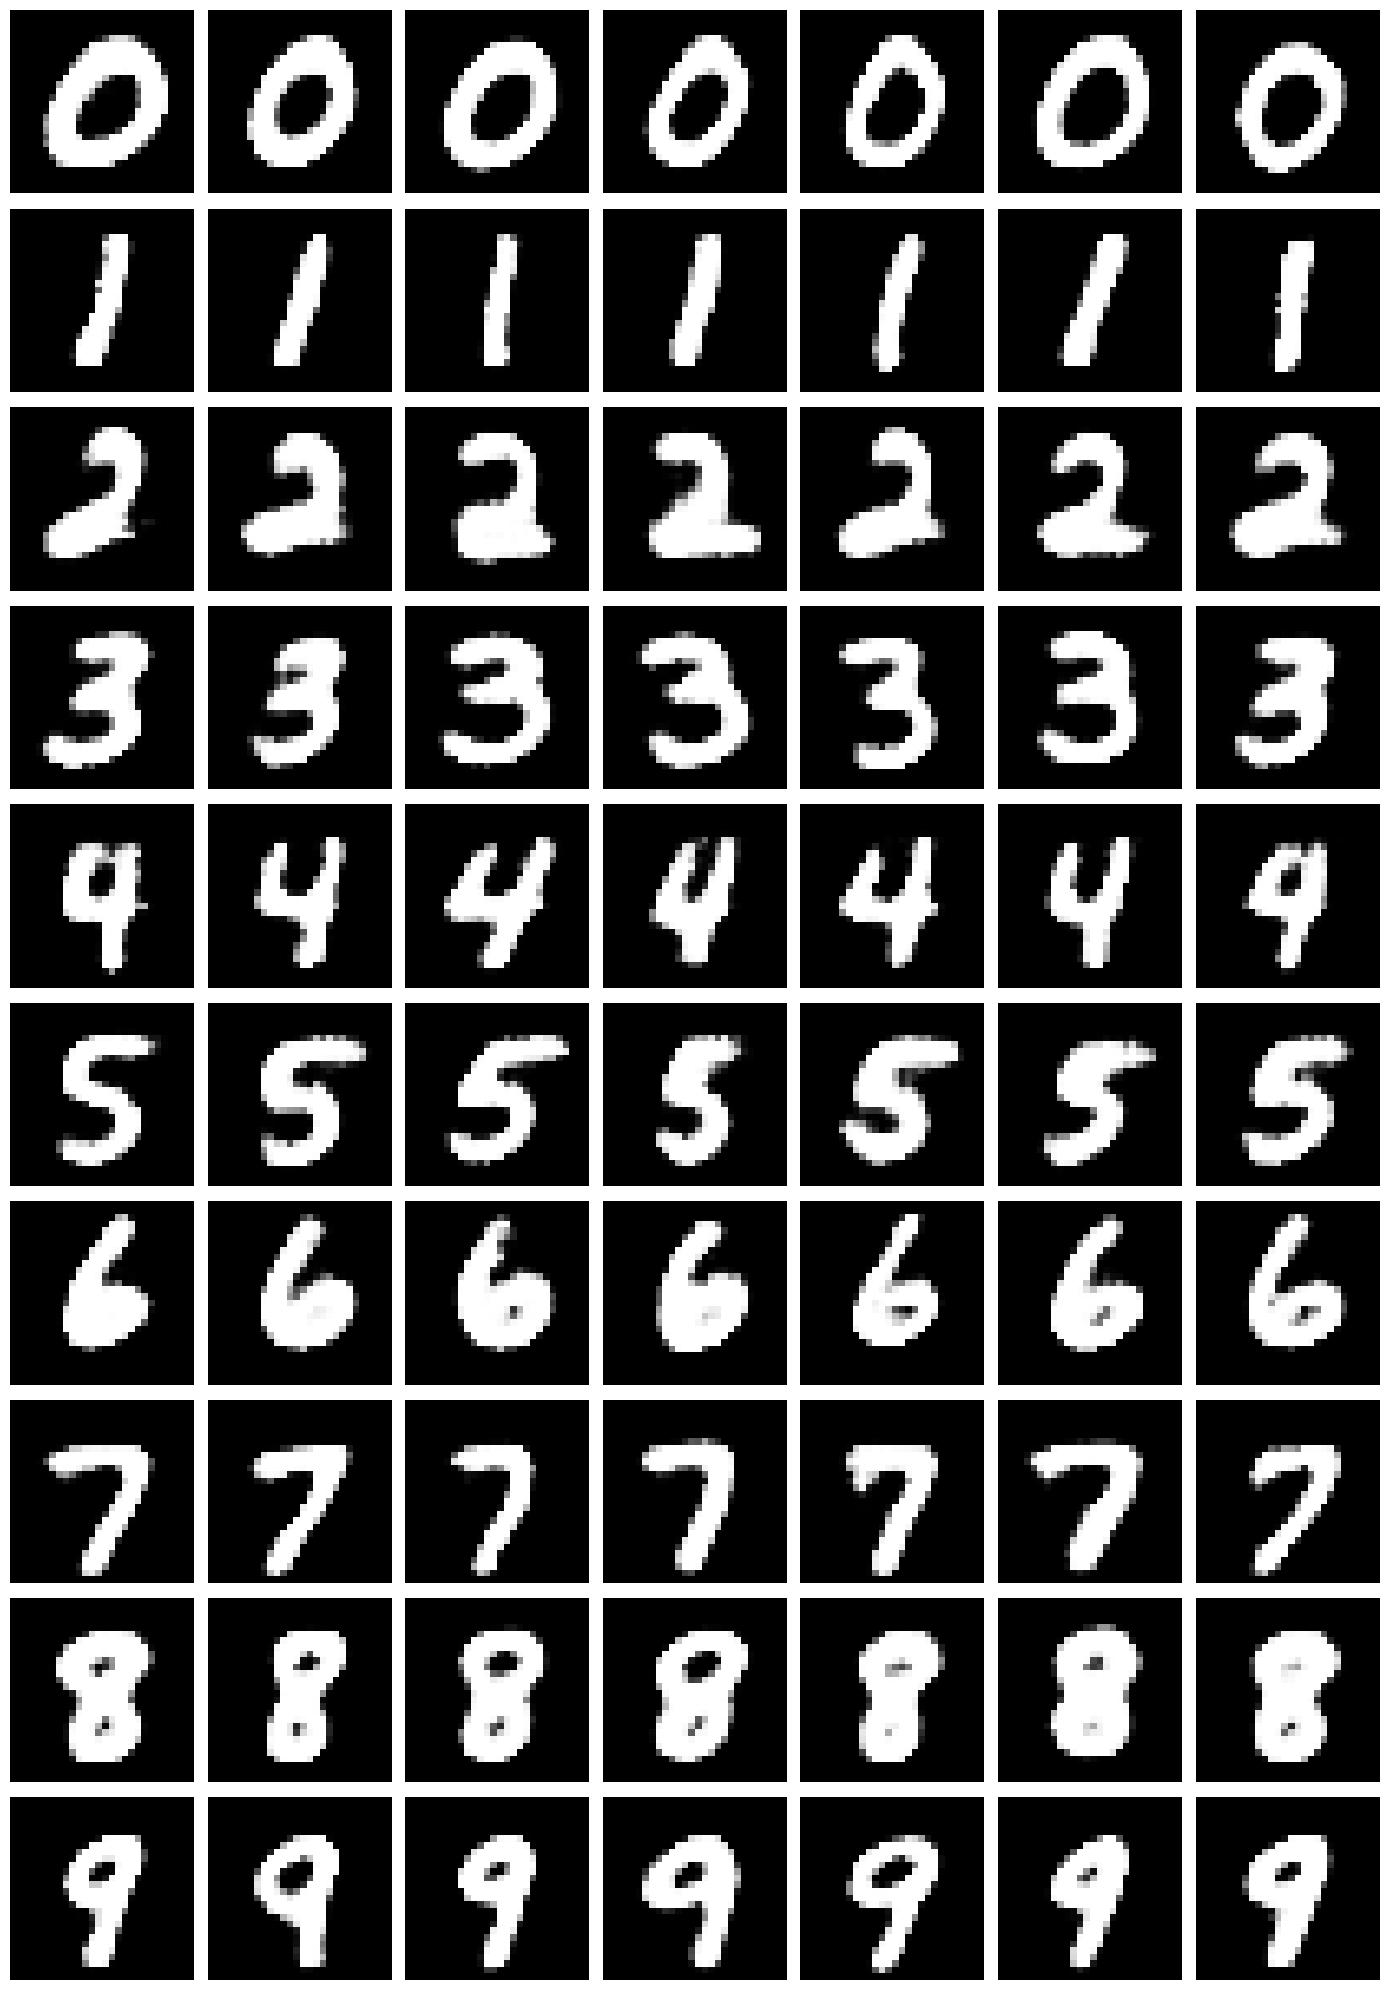

In [19]:
samples = {}
for label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    samples[label] = generate_samples(beta_cvae, 7, label, variance_scaling=0.5, mode="cvae")
display_numbers_grid(samples, path="image/betacvae/sample.jpg")

### 3.5) Generative Adversarial Network

Now, let’s try a completely different architecture. GANs consist of a generator and a discriminator. The goal of the generator is to create images that are indistinguishable from the original input images, while the discriminator tries to accurately determine whether the images are real or fake. These two components compete against each other ("adversarial"), which helps them improve their respective tasks. At convergence, we end up with a strong generator and discriminator. The generator can then be used to create new images.

In [20]:
gan = GAN(learning_rate=LEARNING_RATE, epochs=int(EPOCHS * 0.1), verbose=VERBOSE)
gan.fit(X_train)

Epoch 5/5 - G Loss: 0.6828 - D Loss: 1.0477

#### 3.5.1) Generating Samples

Now, let’s generate a few images.

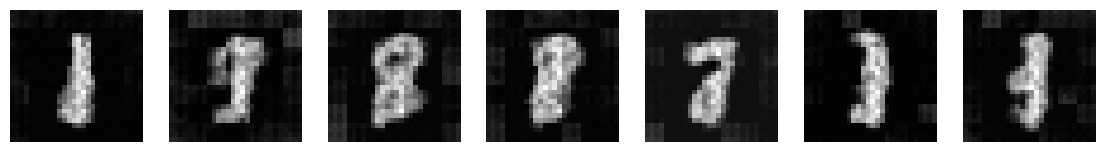

In [21]:
samples = generate_samples(gan, 7, variance_scaling=0.35, mode="gan")
display_numbers(samples, path="image/gan/sample.jpg")